In [49]:
import sys
import os
#import torch
import zarr
import fsspec
import lilio
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt

#from torch import nn
from pathlib import Path
from scipy.stats import pearsonr, spearmanrr

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from scripts.prepare_monthly_ts_data import get_monthly_data

### Defining predictand

In [2]:
# blocks to include and exclude. Lonmin, latmin, lonmax, latmax
include = {'iberia':(-9.8,35.98,3.6,43.8),
          'france_italy':(4,43,13.4,45.63)}
exclude = {'islands':(0.79,35.2,4.6,40.4),
          'north_africa':(-1.450,34.457,11.217,36.972)}

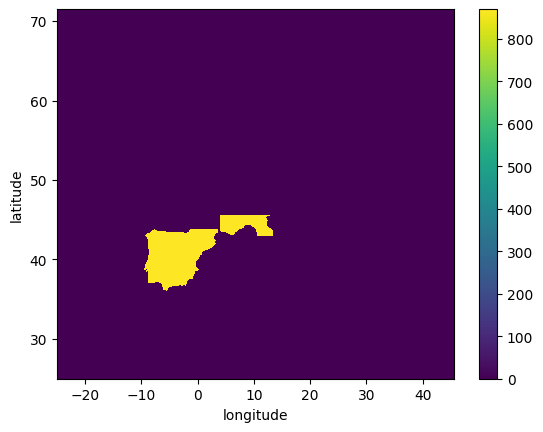

In [3]:
rrmon = xr.open_zarr('/scistor/ivm/jsn295/Medi/monthly/rr_mon_ens_mean_0.1deg_reg_v26.0e.zarr/')['rr']
example = rrmon.isel(time = 0, drop =True)
mask = xr.DataArray(np.full_like(example, 0), coords = example.coords)
def set_subset_to(lonmin, latmin, lonmax, latmax, array, value):
    lons = array.sel(longitude = slice(lonmin, lonmax)).longitude
    lats = array.sel(latitude = slice(latmin, latmax)).latitude
    array.loc[lats,lons] = value # cannot do .sel based assignment
for args in include.values():
    set_subset_to(*args, array = mask, value = 1)
for args in exclude.values():
    set_subset_to(*args, array = mask, value = 0)
count = xr.where(mask,rrmon,np.nan).count('time').compute()
count.plot()

In [73]:
df = get_monthly_data().to_pandas()
df = df.loc[target.index,:]

In [75]:
target = xr.where(mask,rrmon,np.nan).mean(['longitude','latitude']).compute().to_dataframe(name = 'rrmon')
target.columns = pd.MultiIndex.from_tuples([('rrmon',0,'EOBS')], names = df.columns.names)

## trends in predictors

In [109]:
cal = lilio.Calendar(anchor = '12-01')
#cal.add_intervals("target", length="1M", gap = '0M')
cal.add_intervals("precursor", length="1M", n=1, gap = '-1M') # Fully co-occurring
cal.add_intervals("precursor", length="1M", n=3, gap = '0M') # Fully co-occurring
cal.map_years(start=1949, end=2022)

Calendar(
    anchor='12-01',
    allow_overlap=False,
    mapping=('years', 1949, 2022),
    intervals=[
        Interval(role='precursor', length='1M', gap='-1M'),
        Interval(role='precursor', length='1M', gap='0M'),
        Interval(role='precursor', length='1M', gap='0M'),
        Interval(role='precursor', length='1M', gap='0M')
    ]
)

In [110]:
cal.show()

i_interval,-4,-3,-2,-1
anchor_year,,,,
2022,"[2022-09-01, 2022-10-01)","[2022-10-01, 2022-11-01)","[2022-11-01, 2022-12-01)","[2022-12-01, 2023-01-01)"
2021,"[2021-09-01, 2021-10-01)","[2021-10-01, 2021-11-01)","[2021-11-01, 2021-12-01)","[2021-12-01, 2022-01-01)"
2020,"[2020-09-01, 2020-10-01)","[2020-10-01, 2020-11-01)","[2020-11-01, 2020-12-01)","[2020-12-01, 2021-01-01)"
2019,"[2019-09-01, 2019-10-01)","[2019-10-01, 2019-11-01)","[2019-11-01, 2019-12-01)","[2019-12-01, 2020-01-01)"
2018,"[2018-09-01, 2018-10-01)","[2018-10-01, 2018-11-01)","[2018-11-01, 2018-12-01)","[2018-12-01, 2019-01-01)"
...,...,...,...,...
1953,"[1953-09-01, 1953-10-01)","[1953-10-01, 1953-11-01)","[1953-11-01, 1953-12-01)","[1953-12-01, 1954-01-01)"
1952,"[1952-09-01, 1952-10-01)","[1952-10-01, 1952-11-01)","[1952-11-01, 1952-12-01)","[1952-12-01, 1953-01-01)"
1951,"[1951-09-01, 1951-10-01)","[1951-10-01, 1951-11-01)","[1951-11-01, 1951-12-01)","[1951-12-01, 1952-01-01)"


In [23]:
df

name            enso                                               amo  \
subindex          1         2         3         34        4         0    
product      ersstv5   ersstv5   ersstv5   ersstv5   ersstv5   ersstv5   
time                                                                     
1950-01-01 -1.927390 -1.927390 -1.927390 -1.753200 -0.965566  0.184887   
1950-02-01 -1.218390 -1.218390 -1.218390 -1.385940 -1.156580  0.089910   
1950-03-01 -0.270468 -0.270468 -0.270468 -1.027120 -1.529830 -0.050425   
1950-04-01 -0.549984 -0.549984 -0.549984 -1.111260 -1.323680  0.002725   
1950-05-01 -0.928327 -0.928327 -0.928327 -1.231100 -0.452432  0.011638   
...              ...       ...       ...       ...       ...       ...   
2022-02-01 -1.653310 -1.653310 -1.653310 -1.251080 -0.508280  0.400547   
2022-03-01 -1.067890 -1.067890 -1.067890 -1.356780 -0.944791  0.176606   
2022-04-01 -1.121950 -1.121950 -1.121950 -1.431140 -0.984150  0.137476   
2022-05-01 -1.154080 -1.154080 -1.154080 -1.316010 -0.908985  0.234630   
2022-06-01 -0.906488 -0.906488 -0.906488 -0.876785 -0.853466 -0.080667   

name                  amoc   nao          ... med_u500                 \
subindex                0     0           ...       30   40   50   60   
product      hadsst4 rapid  ncep station  ...     era5 era5 era5 era5   
time                                      ...                           
1950-01-01  0.297333   NaN  0.56   0.549  ...      NaN  NaN  NaN  NaN   
1950-02-01  0.235454   NaN  0.01   3.306  ...      NaN  NaN  NaN  NaN   
1950-03-01  0.024343   NaN -0.78   0.815  ...      NaN  NaN  NaN  NaN   
1950-04-01  0.013933   NaN  0.65   1.605  ...      NaN  NaN  NaN  NaN   
1950-05-01  0.048194   NaN -0.50  -1.731  ...      NaN  NaN  NaN  NaN   
...              ...   ...   ...     ...  ...      ...  ...  ...  ...   
2022-02-01  0.392323   NaN  1.46   3.340  ...      NaN  NaN  NaN  NaN   
2022-03-01  0.188116   NaN  0.40  -0.335  ...      NaN  NaN  NaN  NaN   
2022-04-01  0.157599   NaN -0.54  -2.300  ...      NaN  NaN  NaN  NaN   
2022-05-01  0.303258   NaN  0.71   2.072  ...      NaN  NaN  NaN  NaN   
2022-06-01  0.048587   NaN  0.19  -0.337  ...      NaN  NaN  NaN  NaN   

name       atl_u500_latmax atl_u500                      
subindex                0        20   30   40   50   60  
product               era5     era5 era5 era5 era5 era5  
time                                                     
1950-01-01             NaN      NaN  NaN  NaN  NaN  NaN  
1950-02-01             NaN      NaN  NaN  NaN  NaN  NaN  
1950-03-01             NaN      NaN  NaN  NaN  NaN  NaN  
1950-04-01             NaN      NaN  NaN  NaN  NaN  NaN  
1950-05-01             NaN      NaN  NaN  NaN  NaN  NaN  
...                    ...      ...  ...  ...  ...  ...  
2022-02-01             NaN      NaN  NaN  NaN  NaN  NaN  
2022-03-01             NaN      NaN  NaN  NaN  NaN  NaN  
2022-04-01             NaN      NaN  NaN  NaN  NaN  NaN  
2022-05-01             NaN      NaN  NaN  NaN  NaN  NaN  
2022-06-01             NaN      NaN  NaN  NaN  NaN  NaN  

[870 rows x 42 columns]

In [37]:
test = lilio.resample(cal,df, how = 'nanmean').set_index('anchor_year').iloc[:,2:-1]
test.columns = pd.MultiIndex.from_tuples(test.columns, names = df.columns.names)

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

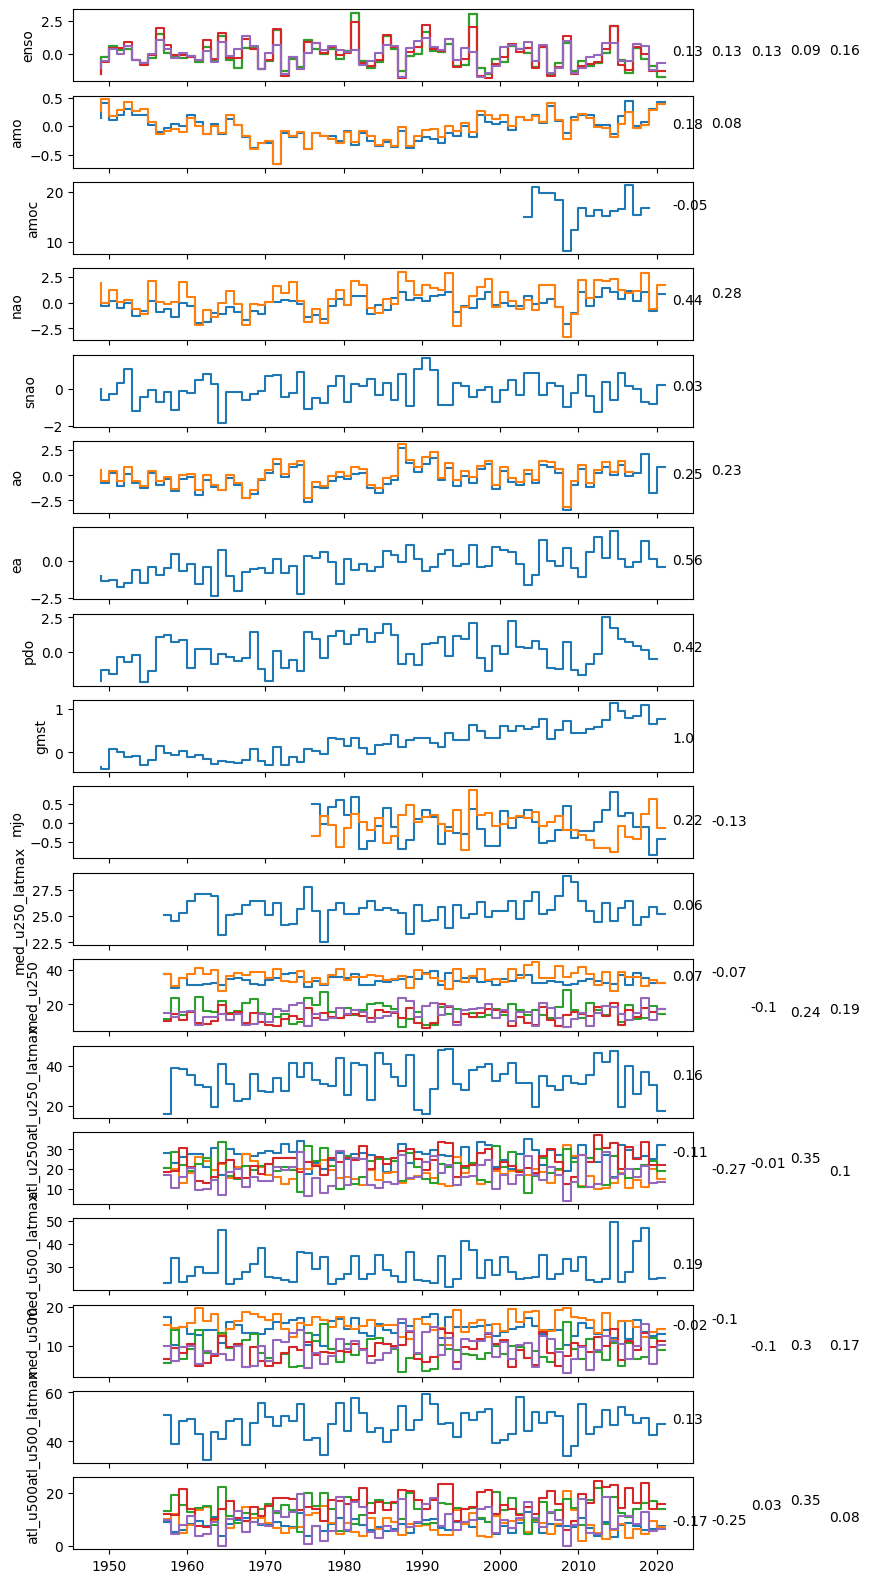

In [66]:
gmst = test['gmst'].squeeze()
names = test.columns.get_level_values('name').unique()
fig, axes = plt.subplots(nrows = len(names), sharex = True, figsize = (8,20))
for i, name in enumerate(names):
    ax = axes[i]
    dat = test.loc[:,name]
    for j,col in enumerate(dat.columns):
        series = dat[col]
        corr = pearsonr(gmst.loc[~series.isnull()],series.loc[~series.isnull()])
        ax.text(2022+5*j,series.mean(), s = np.round(corr[0],2))
        ax.step(test.index, series, label = col)
    ax.set_ylabel(name)

East Atlantic pattern pretty trended. Strong correlation with GMST
Also the blue NAO index is quite trended.

#### Correlation Matrices at multiple timescales.

In [158]:
def simultaneous_resample(firstmonth = 12, lastmonth = 1, average = True):
    """
    lastmonth is inclusive
    """
    combined = df.join(target)
    if firstmonth > lastmonth:
        months = np.arange(firstmonth - 12, lastmonth + 1, 1)
        months  = np.where(months <=0, months + 12, months)
    else:
        months = np.arange(firstmonth, lastmonth + 1, 1)
    if average:
        cal = lilio.Calendar(anchor = f'{firstmonth}-01')
        cal.add_intervals("precursor", length=f"{len(months)}M", n=1, gap = f'-{len(months)}M') # Fully co-occurring
    else:
        cal = lilio.Calendar(anchor = f'{lastmonth}-01')
        cal.add_intervals("precursor", length="1M", n=1, gap = '-1M') # Fully co-occurring
        if len(months) > 1:
            cal.add_intervals("precursor", length="1M", n=len(months)-1, gap = '0M') # Fully co-occurring
    cal.map_years(start=1949, end=2023)
    res = lilio.resample(cal, combined, how = 'nanmean')
    res = res.set_index(['anchor_year','i_interval','interval']).drop('is_target', axis = 1) # Lilio bookkeeping
    res.columns = pd.MultiIndex.from_tuples(res.columns, names = df.columns.names)
    return res

In [159]:
test = simultaneous_resample(firstmonth = 1, lastmonth = 3, average = False)

/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV/lib/python3.10/site-packages/lilio/resampling.py:165: RuntimeWarning: Mean of empty slice
  resampled_data[i] = resampling_method(input_data[colname].values[row])
/scistor/ivm/jsn295/NEWJUPVENV

In [160]:
# Plotting correlations per month, single months
corwith = 'gmst'
months = [10,11,12,1,2,3,4,5]
for month in months:
    pass

name                                                 enso                      \
subindex                                               1         2         3    
product                                           ersstv5   ersstv5   ersstv5   
anchor_year i_interval interval                                                 
1949        -3         [1949-01-01, 1949-02-01)       NaN       NaN       NaN   
            -2         [1949-02-01, 1949-03-01)       NaN       NaN       NaN   
            -1         [1949-03-01, 1949-04-01)       NaN       NaN       NaN   
1950        -3         [1950-01-01, 1950-02-01) -1.927390 -1.927390 -1.927390   
            -2         [1950-02-01, 1950-03-01) -1.218390 -1.218390 -1.218390   
...                                                   ...       ...       ...   
2021        -2         [2021-02-01, 2021-03-01) -0.921131 -0.921131 -0.921131   
            -1         [2021-03-01, 2021-04-01) -0.883151 -0.883151 -0.883151   
2022        -3         [2022-01-01, 2022-02-01) -1.893430 -1.893430 -1.893430   
            -2         [2022-02-01, 2022-03-01) -1.653310 -1.653310 -1.653310   
            -1         [2022-03-01, 2022-04-01) -1.067890 -1.067890 -1.067890   

name                                                                      amo  \
subindex                                               34        4         0    
product                                           ersstv5   ersstv5   ersstv5   
anchor_year i_interval interval                                                 
1949        -3         [1949-01-01, 1949-02-01)       NaN       NaN       NaN   
            -2         [1949-02-01, 1949-03-01)       NaN       NaN       NaN   
            -1         [1949-03-01, 1949-04-01)       NaN       NaN       NaN   
1950        -3         [1950-01-01, 1950-02-01) -1.753200 -0.965566  0.184887   
            -2         [1950-02-01, 1950-03-01) -1.385940 -1.156580  0.089910   
...                                                   ...       ...       ...   
2021        -2         [2021-02-01, 2021-03-01) -1.224780 -1.139690  0.407269   
            -1         [2021-03-01, 2021-04-01) -0.998302 -0.732910  0.230616   
2022        -3         [2022-01-01, 2022-02-01) -1.393060 -0.627015  0.440420   
            -2         [2022-02-01, 2022-03-01) -1.251080 -0.508280  0.400547   
            -1         [2022-03-01, 2022-04-01) -1.356780 -0.944791  0.176606   

name                                                       amoc   nao          \
subindex                                                     0     0            
product                                           hadsst4 rapid  ncep station   
anchor_year i_interval interval                                                 
1949        -3         [1949-01-01, 1949-02-01)       NaN   NaN   NaN     NaN   
            -2         [1949-02-01, 1949-03-01)       NaN   NaN   NaN     NaN   
            -1         [1949-03-01, 1949-04-01)       NaN   NaN   NaN     NaN   
1950        -3         [1950-01-01, 1950-02-01)  0.297333   NaN  0.56   0.549   
            -2         [1950-02-01, 1950-03-01)  0.235454   NaN  0.01   3.306   
...                                                   ...   ...   ...     ...   
2021        -2         [2021-02-01, 2021-03-01)  0.352561   NaN -0.29   0.497   
            -1         [2021-03-01, 2021-04-01)  0.255102   NaN  0.36   0.716   
2022        -3         [2022-01-01, 2022-02-01)  0.311665   NaN  0.74   1.462   
            -2         [2022-02-01, 2022-03-01)  0.392323   NaN  1.46   3.340   
            -1         [2022-03-01, 2022-04-01)  0.188116   NaN  0.40  -0.335   

name                                             ...   med_u500             \
subindex                                         ...         40         50   
product                                          ...       era5       era5   
anchor_year i_interval interval                  ...                         
1949        -3         [1949-01-01, 1949

(enso, 1, ersstv5)  \
anchor_year i_interval interval                                       
1949        -3         [1949-01-01, 1949-02-01)                 NaN   
            -2         [1949-02-01, 1949-03-01)                 NaN   
            -1         [1949-03-01, 1949-04-01)                 NaN   
1950        -3         [1950-01-01, 1950-02-01)           -1.927390   
            -2         [1950-02-01, 1950-03-01)           -1.218390   
...                                                             ...   
2021        -2         [2021-02-01, 2021-03-01)           -0.921131   
            -1         [2021-03-01, 2021-04-01)           -0.883151   
2022        -3         [2022-01-01, 2022-02-01)           -1.893430   
            -2         [2022-02-01, 2022-03-01)           -1.653310   
            -1         [2022-03-01, 2022-04-01)           -1.067890   

                                                 (enso, 2, ersstv5)  \
anchor_year i_interval interval                                       
1949        -3         [1949-01-01, 1949-02-01)                 NaN   
            -2         [1949-02-01, 1949-03-01)                 NaN   
            -1         [1949-03-01, 1949-04-01)                 NaN   
1950        -3         [1950-01-01, 1950-02-01)           -1.927390   
            -2         [1950-02-01, 1950-03-01)           -1.218390   
...                                                             ...   
2021        -2         [2021-02-01, 2021-03-01)           -0.921131   
            -1         [2021-03-01, 2021-04-01)           -0.883151   
2022        -3         [2022-01-01, 2022-02-01)           -1.893430   
            -2         [2022-02-01, 2022-03-01)           -1.653310   
            -1         [2022-03-01, 2022-04-01)           -1.067890   

                                                 (enso, 3, ersstv5)  \
anchor_year i_interval interval                                       
1949        -3         [1949-01-01, 1949-02-01)                 NaN   
            -2         [1949-02-01, 1949-03-01)                 NaN   
            -1         [1949-03-01, 1949-04-01)                 NaN   
1950        -3         [1950-01-01, 1950-02-01)           -1.927390   
            -2         [1950-02-01, 1950-03-01)           -1.218390   
...                                                             ...   
2021        -2         [2021-02-01, 2021-03-01)           -0.921131   
            -1         [2021-03-01, 2021-04-01)           -0.883151   
2022        -3         [2022-01-01, 2022-02-01)           -1.893430   
            -2         [2022-02-01, 2022-03-01)           -1.653310   
            -1         [2022-03-01, 2022-04-01)           -1.067890   

                                                 (enso, 34, ersstv5)  \
anchor_year i_interval interval                                        
1949        -3         [1949-01-01, 1949-02-01)                  NaN   
            -2         [1949-02-01, 1949-03-01)                  NaN   
            -1         [1949-03-01, 1949-04-01)                  NaN   
1950        -3         [1950-01-01, 1950-02-01)            -1.753200   
            -2         [1950-02-01, 1950-03-01)            -1.385940   
...                                                              ...   
2021        -2         [2021-02-01, 2021-03-01)            -1.224780   
            -1         [2021-03-01, 2021-04-01)            -0.998302   
2022        -3         [2022-01-01, 2022-02-01)            -1.393060   
            -2         [2022-02-01, 2022-03-01)            -1.251080   
            -1         [2022-03-01, 2022-04-01)            -1.356780   

                                                 (enso, 4, ersstv5)  \
anchor_year i_interval interval                                       
1949        -3         [1949-01-01, 1949-02-01)                 NaN   
            -2         [1949-02-01, 1949-03-01)                 NaN   
            -1         [1949-03-01, 1949-04-01)         

In [113]:
12-12

0

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to('cuda')

In [ ]:
model(torch.randn((784,)).to('cuda'))